## Portfolio Project # 5
### Economic Sentiment Analysis with Twitter’s API
##### https://developer.twitter.com/en/docs/twitter-api/tutorials

October 5, 2022


The initial goal for this project is to conduct economic sentiment analyses in the US using Twitter data. Twitter granted my developer account elevated access to the Twitter API. Scraped Tweets will be fed into Sentiment Analysis libraries (e.g. TextBlob or Vader Sentiment: https://github.com/cjhutto/vaderSentiment) and Natural Language Processing libraries (e.g. NLTK: https://www.nltk.org/). Currently, elevated access only allows searching for the past 7 days of Tweets.

Initial questions to explore: What are the current overall sentiments of the economy? Are they positive or negative or neutral? How has it varied over time? Is there a correlation between economic sentiment and perhaps certain economic metrics such as stock market performance?

https://developer.twitter.com/en/docs/twitter-api/tutorials

Skills: Python; Twitter API; Tweepy; Pandas; Vader; NLTK; Matplotlib; Seaborn; Data Munging; Feature Engineering.


References for documentation and starter code:
<br>1. Getting started with the Twitter API v2 for academic research
<br>&emsp;&emsp; https://github.com/twitterdev/getting-started-with-the-twitter-api-v2-for-academic-research
<br>2. A comprehensive guide for using the Twitter API v2 with Tweepy in Python
<br>&emsp;&emsp; https://dev.to/twitterdev/a-comprehensive-guide-for-using-the-twitter-api-v2-using-tweepy-in-python-15d9
<br>3. How to use the Twitter API v2 in Python using Tweepy
<br>&emsp;&emsp; https://www.youtube.com/watch?v=0EekpQBEP_8&t=758s
<br>4. Building queries for Search Tweets
<br>&emsp;&emsp; https://developer.twitter.com/en/docs/twitter-api/tweets/search/integrate/build-a-query
<br>5. Twitter API v2 data dictionary
<br>&emsp;&emsp; https://developer.twitter.com/en/docs/twitter-api/data-dictionary/object-model/tweet
<br>6. Introduction to Twitter data processing and storage on AWS
<br>&emsp;&emsp; https://dev.to/twitterdev/introduction-to-twitter-data-processing-and-storage-on-aws-1og
<br>7. A Complete Step by Step Tutorial on Sentiment Analysis in Keras and Tensorflow
<br>&emsp;&emsp; https://towardsdatascience.com/a-complete-step-by-step-tutorial-on-sentiment-analysis-in-keras-and-tensorflow-ea420cc8913f

Notes:
1. Searching for Tweets from the last 7 days
13. Keeping your dataset compliant
<br>https://github.com/twitterdev/getting-started-with-the-twitter-api-v2-for-academic-research/blob/main/modules/6b-labs-code-standard-python.md



In [20]:
# # Use datatable to speed up the process of loading data?
# import datatable as dt  # pip install datatable
# %%time
# tps_dt_october = dt.fread("data/train.csv").to_pandas()

### Script below to be run once on AWS to instantiate a MySQL database.

In [21]:
"""Using MySQL to practice deploying to the cloud with the idea that the database 
will grow every day and feed a website showing economic sentiment Twitter metrics.
MySQL was chosen due to ease and widespread use. It is more efficient than pandas 
which is more computationally intensive to add rows to daily."""

import mysql.connector

In [22]:
import config    # Config file is used to keep passwords & keys for MySQL & Twitter.

mydb = mysql.connector.connect(
    host = config.HOST,
    user = config.USER,
    passwd = config.PASSWD,
    use_pure = True)

print(mydb)
db_cursor = mydb.cursor(buffered=True)
# Create database
db_cursor.execute("DROP DATABASE IF EXISTS econ_tweets") # comment line out when DB fully configured
db_cursor.execute("CREATE DATABASE econ_tweets")

In [23]:
import os

host = os.getenv('MYSQL_HOST')
port = os.getenv('MYSQL_PORT')
user = os.getenv('MYSQL_USER')
password = os.getenv('MYSQL_PASSWORD')
database = os.getenv('MYSQL_DATABASE')

print(password)

None


In [24]:
mydb = mysql.connector.connect(
    host = config.HOST,
    user = config.USER,
    passwd = config.PASSWD,
    db = 'econ_tweets',
    use_pure = True
)
print(mydb)
db_cursor = mydb.cursor(buffered=True)
#Create database table with date as primary key
db_cursor.execute("CREATE TABLE tweets(date DATE PRIMARY KEY, mentions INT(255))")
#Get database table
db_cursor.execute("SHOW TABLES")
for table in db_cursor:
    print(table)
db_cursor.close()

('tweets',)


True

### Script below to be run daily on AWS.

In [25]:
import tweepy
import config    # Config file is used to keep passwords & keys for MySQL & Twitter.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
client = tweepy.Client(bearer_token=config.BEARER_TOKEN)

In [27]:
query = '#Economy -is:retweet lang:en'

In [28]:
# This does not subtract from monthly tweet limit.
counts = client.get_recent_tweets_count(query=query, granularity='day')

In [29]:
# To check API payload:

# for count in counts.data:
#     print(count)

In [30]:
from datetime import datetime

dates = []
tweets = []
for count in counts.data:
    date = datetime.strptime(count['end'][:10], '%Y-%m-%d')
    # API payload includes 2 end dates for the current date with the 1st being the full day so the last date needs to be ignored.
    if date in dates:
        break
    else:
        dates.append(date)
        tweets.append(count['tweet_count'])
tups = tuple(zip(dates, tweets))
tups

((datetime.datetime(2022, 10, 22, 0, 0), 1865),
 (datetime.datetime(2022, 10, 23, 0, 0), 1292),
 (datetime.datetime(2022, 10, 24, 0, 0), 1085),
 (datetime.datetime(2022, 10, 25, 0, 0), 1973),
 (datetime.datetime(2022, 10, 26, 0, 0), 2164),
 (datetime.datetime(2022, 10, 27, 0, 0), 2136),
 (datetime.datetime(2022, 10, 28, 0, 0), 2195))

In [31]:
mydb = mysql.connector.connect(
    host = config.HOST,
    user = config.USER,
    passwd = config.PASSWD,
    db = 'econ_tweets',
    use_pure = True
)
print(mydb)
db_cursor = mydb.cursor(buffered=True)

# Ignore adding dates that are already in the table:
for item in tups:
    tweets_sql_query = "INSERT IGNORE INTO tweets(date, mentions) VALUES('%s', %i)" %item
    db_cursor.execute(tweets_sql_query)
    mydb.commit()
print(db_cursor.rowcount, "Record Inserted")

1 Record Inserted


In [32]:
# Checking to see if insertions worked:

# db_cursor.execute("SELECT * FROM tweets")
# result = db_cursor.fetchall()
# for row in result:
#     print(row)

In [33]:
# Extracting the data from MySQL using pandas for visualizing:

df = pd.read_sql("SELECT * from tweets", mydb)
pd.set_option('display.expand_frame_repr', False)
db_cursor.close()
print(df)

         date  mentions
0  2022-10-22      1865
1  2022-10-23      1292
2  2022-10-24      1085
3  2022-10-25      1973
4  2022-10-26      2164
5  2022-10-27      2136
6  2022-10-28      2195


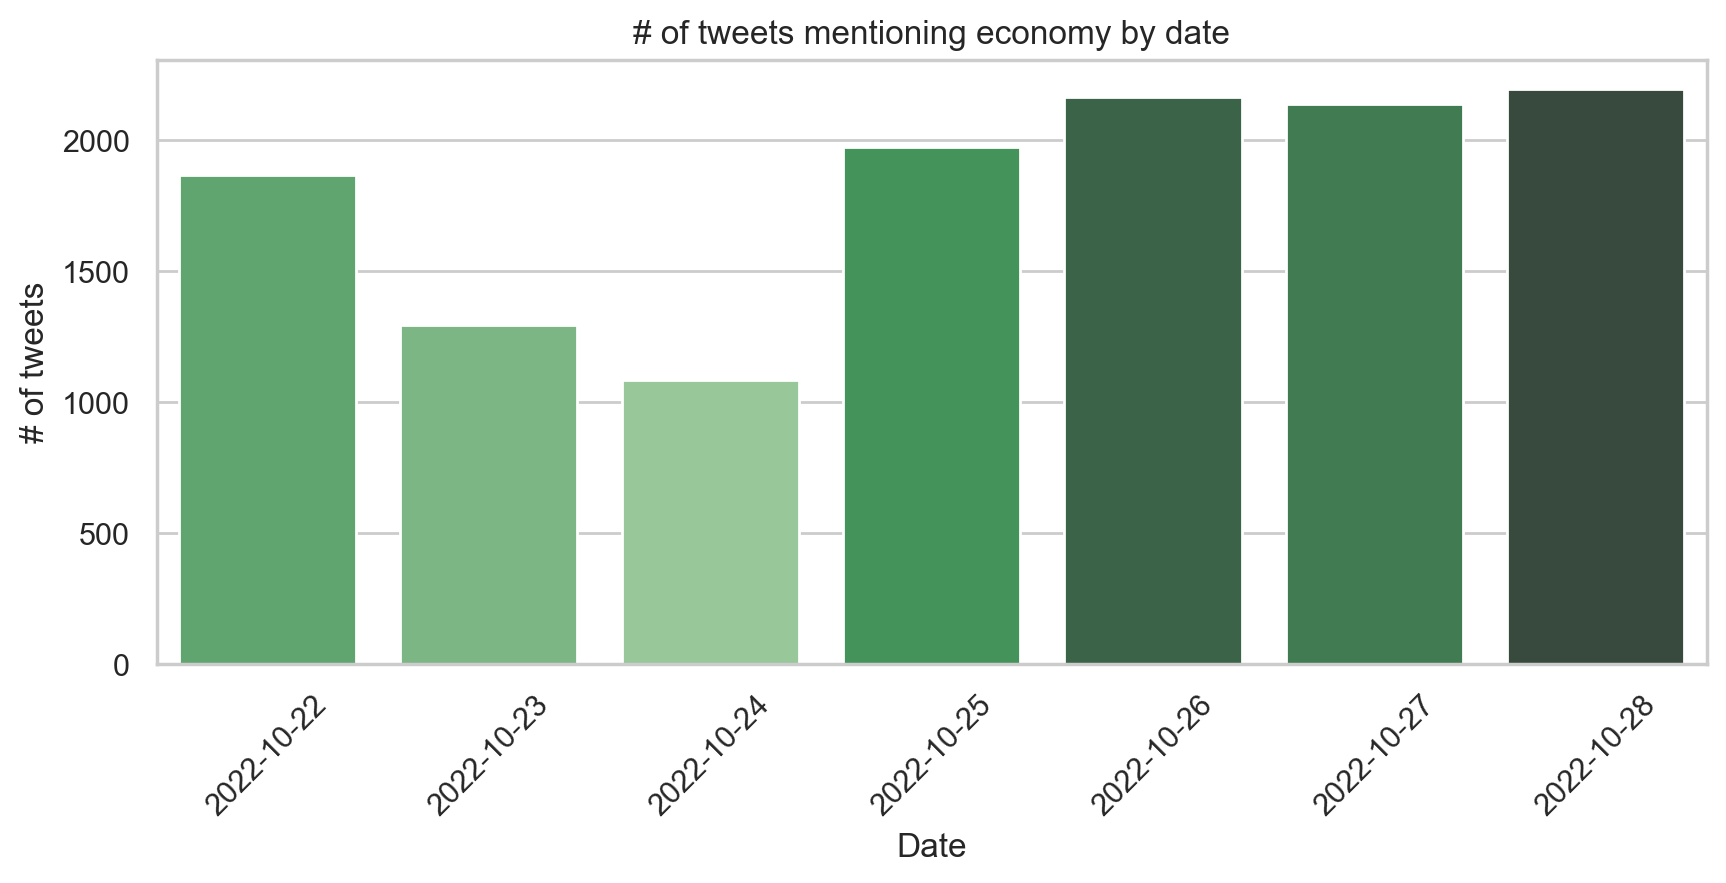

In [34]:
plt.figure(figsize=(10,4), dpi=200)

#  https://stackoverflow.com/questions/36271302/changing-color-scale-in-seaborn-bar-plot
sns.set(style="whitegrid", color_codes=True)
data = df['mentions']
pal = sns.color_palette("Greens_d", len(data))
rank = data.argsort().argsort()   # http://stackoverflow.com/a/6266510/1628638
sns.barplot(x=df['date'], y=df['mentions'], palette=np.array(pal)[rank])

plt.title('# of tweets mentioning economy by date')
plt.xlabel('Date')
plt.ylabel('# of tweets')
plt.xticks(rotation=45)
plt.savefig('tweets_count.png', bbox_inches='tight');

### Below cells are notes for querying and analyzing a tweets payload (in progress)

response = client.search_recent_tweets(query=query, max_results=10,
                                      tweet_fields=['author_id', 'id', 'text', 
                                                    'created_at', 'lang',
                                                    'geo', 'possibly_sensitive'])
# counts = client.get_recent_tweets_count(query=query, granularity='day')

df.loc[len(df)] = ['name5', 9, 0]

print(response)

for tweet in response.data:
    print(tweet.author_id)
    print(tweet.lang)
    print(tweet.created_at)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.DataFrame(data=response.data, columns=['author_id', 'id', 'text', 'created_at', 'lang',
                                               'geo', 'possibly_sensitive'])
df